This notebook is developed as a documentation for experimentation and development of a model for the sacred.ai project created by Vasu Jain, Amee Madhani, Anand Chauhan, and Ananya Chauhan as part of our university course. The project to create one or multiple model in order to answer question based on life, the universe, and everything with the knowledge of several religious texts for Hinduism, Christianity, and Islam.

In [2]:
# import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
print(tf.config.list_physical_devices())

2023-04-10 20:51:54.340321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-04-10 20:51:58.238532: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-10 20:51:58.361902: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-10 20:51:58.361978: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
import spacy
# verifying if cuda setup works properly
spacy.prefer_gpu()

True

Current working approaches include looking to religious semantic searching and question-answering. The latter of these requires an extensive dataset covering a wide variety of questions and associated answers and outputs we'd be looking for, and is therefore hard to implement since we do not know if anything like that even exists (hopefully not lol)

So we'd have to play around a lot with feature extraction, semantics and transformers and their encoding.e

Can't do regression based linear transformations either since that, too, requires a dataset.

Let's just import all our datasets for now.

In [4]:
bhagvadgita = pd.read_csv('../dataset/gitaDataset.csv')
quran = pd.read_csv('../dataset/quranDataset.csv')
bible = pd.read_csv('../dataset/bibleDataset.csv')
print(bhagvadgita.shape)
bhagvadgita.head()

(700, 4)


,Title,Chapter,Verse,English Translation
0,Arjuna's Vishada Yoga,Chapter 1,Verse 1.1,"Dhrtarashtra asked of Sanjaya: O SANJAYA, what..."
1,Arjuna's Vishada Yoga,Chapter 1,Verse 1.2,Sanjaya explained: Now seeing that the army of...
2,Arjuna's Vishada Yoga,Chapter 1,Verse 1.3,"Behold O, Master, the mighty army of the sons ..."
3,Arjuna's Vishada Yoga,Chapter 1,Verse 1.4,"Present here are the mighty archers, peers or ..."
4,Arjuna's Vishada Yoga,Chapter 1,Verse 1.5,"Dhrishtaketu, Chekitana, and the valiant king ..."


In [5]:
bhagvadgita['Title'].unique()

array(["Arjuna's Vishada Yoga", 'Sankhya Yoga', 'Karma Yoga',
       'Jnana-Karma-Sanyasa Yoga', 'Atma-Samyama Yoga',
       'Jnana-Vijnana Yoga', 'Aksara-ParaBrahma Yoga',
       'Raja-Vidya-Raja-Guhya Yoga', 'Vibhuti Yoga',
       'Viswarupa-Darsana Yoga', 'Bhakti Yoga',
       'Ksetra-Ksetrajna-Vibhaga Yoga', 'Gunatraya-Vibhaga Yoga',
       'Purushottama Yoga', 'Daivasura-Sampad-Vibhaga Yoga',
       'Shraddhatraya-Vibhaga Yoga', 'Moksha-Sanyasa Yoga'], dtype=object)

In [6]:
print(quran.shape)
quran.head()

(6236, 5)


,Name,Surah,Ayat,Verse,Tafseer
0,The Opening,1,1,"In the name of Allah, the Beneficent, the Merc...",In the Name of God the Compassionate the Merciful
1,The Opening,1,2,"Praise be to Allah, Lord of the Worlds,",In the Name of God the name of a thing is that...
2,The Opening,1,3,"The Beneficent, the Merciful.",The Compassionate the Merciful that is to say ...
3,The Opening,1,4,"Owner of the Day of Judgment,",Master of the Day of Judgement that is the day...
4,The Opening,1,5,Thee (alone) we worship; Thee (alone) we ask f...,You alone we worship and You alone we ask for ...


In [7]:
print(bible.shape)
bible.head()

(31103, 5)


,field,book,chapter,verse,text
0,1001001,1,1,1,At the first God made the heaven and the earth.
1,1001002,1,1,2,And the earth was waste and without form; and ...
2,1001003,1,1,3,"And God said, Let there be light: and there wa..."
3,1001004,1,1,4,"And God, looking on the light, saw that it was..."
4,1001005,1,1,5,"Naming the light, Day, and the dark, Night. An..."


In [8]:
# whatever approach we implement now we will implement first on the bhagvadgita, since it is the smallest.
# everything else will be taken care of later lmao
try:
    # removing useless text and making everthing integer.
    bhagvadgita['Verse'] = bhagvadgita['Verse'].apply(lambda x: x.split('.')[-1]).astype('int')
    bhagvadgita['Chapter'] = bhagvadgita['Chapter'].apply(lambda x: x.split()[-1]).astype('int')
except AttributeError:
    # circumventing inplace problems
    pass
# check dtypes
bhagvadgita.dtypes

Title                  object
Chapter                 int64
Verse                   int64
English Translation    object
dtype: object

In [9]:
# finding the maximum amonut of words in any single shlok/verse/passage. we will model our max query length around it. maybe.
# every book will therfore contain three tensors. max pooled, mean pooled, and all vectors with a lot of zeroes.
max_length = 0
for i in bhagvadgita['English Translation']:
    if len(i.split()) > max_length:
        max_length = len(i.split())
print(max_length)
for j in bible['text']:
    if len(j.split()) > max_length:
        max_length = len(j.split())
print(max_length)
for k in quran['Verse']:
    if len(k.split()) > max_length:
        max_length = len(k.split())
print(max_length)
for l in quran['Tafseer'].astype('str'):
    if len(l.split()) > max_length:
        max_length = len(l.split())
print(max_length)

118
118
273
584


In [10]:
# MAX_LENGTH = 584 
# best case, let's try smaller sizes first
MAX_LENGTH = 256

In [11]:
# loading the word2vec model that we'll be using for now.
nlp = spacy.load('en_core_web_lg')

In [12]:
# investigating if the standard vector function does max or mean pooling.
lmaobase = np.array([token.vector.get() for token in nlp(bhagvadgita['English Translation'][0])])
lmao = lmaobase.mean(axis=(0))
argm = np.array([float(token.vector_norm) for token in nlp(bhagvadgita['English Translation'][0])])
lmao1 = lmaobase[argm.argmax()]
lmao2 = np.array(nlp(bhagvadgita['English Translation'][0]).vector.get())
lmao3 = lmaobase.max(axis=(0))
print(f"Max v/s overall vector: {np.array_equal(lmao1, lmao2)} \nMean v/s overall vector: {np.array_equal(lmao, lmao2)} \nMax v/s Argmax vector: {np.array_equal(lmao1, lmao3)}")

Max v/s overall vector: False 
Mean v/s overall vector: True 
Max v/s Argmax vector: False


In [13]:
# experimenting with how to make a vector with all zeroes
# find a zero vector
zerosample = np.array(nlp(bhagvadgita['English Translation'][0].split()[0]).vector.get())
constructedzeros = np.zeros((300,))
np.array_equal(constructedzeros, zerosample)
zerosample = np.array([token.vector.get() for token in nlp(bhagvadgita['English Translation'][0])])
constructarr = np.zeros((MAX_LENGTH - zerosample.shape[0], 300))
hope = np.append(zerosample, constructarr, axis=(0))
hope.shape

(256, 300)

# IT WORKS!!

With this we can see that spacy's `en_core_web_lg` uses mean pooling. so we can make our data as follows:

In [14]:
# converting this to a function for later use:
def tensorgoBrr(df: pd.DataFrame, column: str):
    """this function returns tensors for max pooled, mean pooled, and all present (padded up or down to 256 vectors)
    the return is a tuple with the order max, mean, and all tokens respectively."""
    maxtokens = []
    meantokens = []
    alltokens = []

    for i in df[column].astype('string'):
        doc = nlp(str(i))
        tokenlist = np.array([token.vector.get() for token in doc])
        maxnormlist = np.array([float(token.vector_norm) for token in doc])
        if MAX_LENGTH - tokenlist.shape[0] > 0:
            constructarr = np.zeros((MAX_LENGTH - tokenlist.shape[0], 300))
            alltokens.append(np.append(tokenlist, constructarr, axis=(0)))
        else:
            alltokens.append(tokenlist[:MAX_LENGTH])

        maxtokens.append(np.array(tokenlist[maxnormlist.argmax()]))
        meantokens.append(np.array(tokenlist.mean(axis=(0))))

    tmaxtokens = tf.convert_to_tensor(maxtokens)
    tmeantokens = tf.convert_to_tensor(meantokens)
    talltokens = tf.convert_to_tensor(alltokens)

    return (tmaxtokens, tmeantokens, talltokens)

In [15]:
# implementing a simple script for plotting the loss curves.
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(20,10))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

We have now created the tensors for all verses of the bhagvadgita. for the demo this is all that we wil be doing.

Bear in mind that the tensor with all adjusted vectors for the Bhagvadgita alone is over 400 MB, which, considering my system VRAM of 8GB, might become a computational power problem later down the line.

In [16]:
# importing all AI experimentation libraries.
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import keras
from keras import layers
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Reshape, Flatten
from keras.utils import plot_model

In [107]:
timesteps = talltokens.shape[1]  # Length of your sequences
input_dim = talltokens.shape[2]
latent_dim = 64

input_img = keras.Input(shape=(256, 300))

x = layers.Conv1D(300/5, (5), activation='tanh', padding='same')(input_img)
# x = layers.MaxPooling1D((8), padding='same')(x)
x = layers.Conv1D(60/3, (3), activation='relu', padding='same')(x)
# x = layers.MaxPooling1D((8), padding='same')(x)
x = layers.Conv1D(20/2, (3), activation='relu', padding='same')(x)
# encoded = layers.MaxPooling1D((4), padding='same')(x)
encoded = x

x = layers.Conv1D(20, (3), activation='tanh', padding='same')(encoded)
x = layers.UpSampling1D((1))(x)
x = layers.Conv1D(60, (3), activation='relu', padding='same')(x)
x = layers.UpSampling1D((1))(x)
x = layers.Conv1D(300, (1), activation='relu')(x)
x = layers.UpSampling1D((1))(x)
decoded = layers.Conv1D(300, (5), activation='relu', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss=['cosine_similarity'], metrics=['mse'])
autoencoder.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 300)]        0         
                                                                 
 conv1d_42 (Conv1D)          (None, 256, 60)           90060     
                                                                 
 conv1d_43 (Conv1D)          (None, 256, 20)           3620      
                                                                 
 conv1d_44 (Conv1D)          (None, 256, 10)           610       
                                                                 
 conv1d_45 (Conv1D)          (None, 256, 20)           620       
                                                                 
 up_sampling1d_18 (UpSamplin  (None, 256, 20)          0         
 g1D)                                                            
                                                          

In [108]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


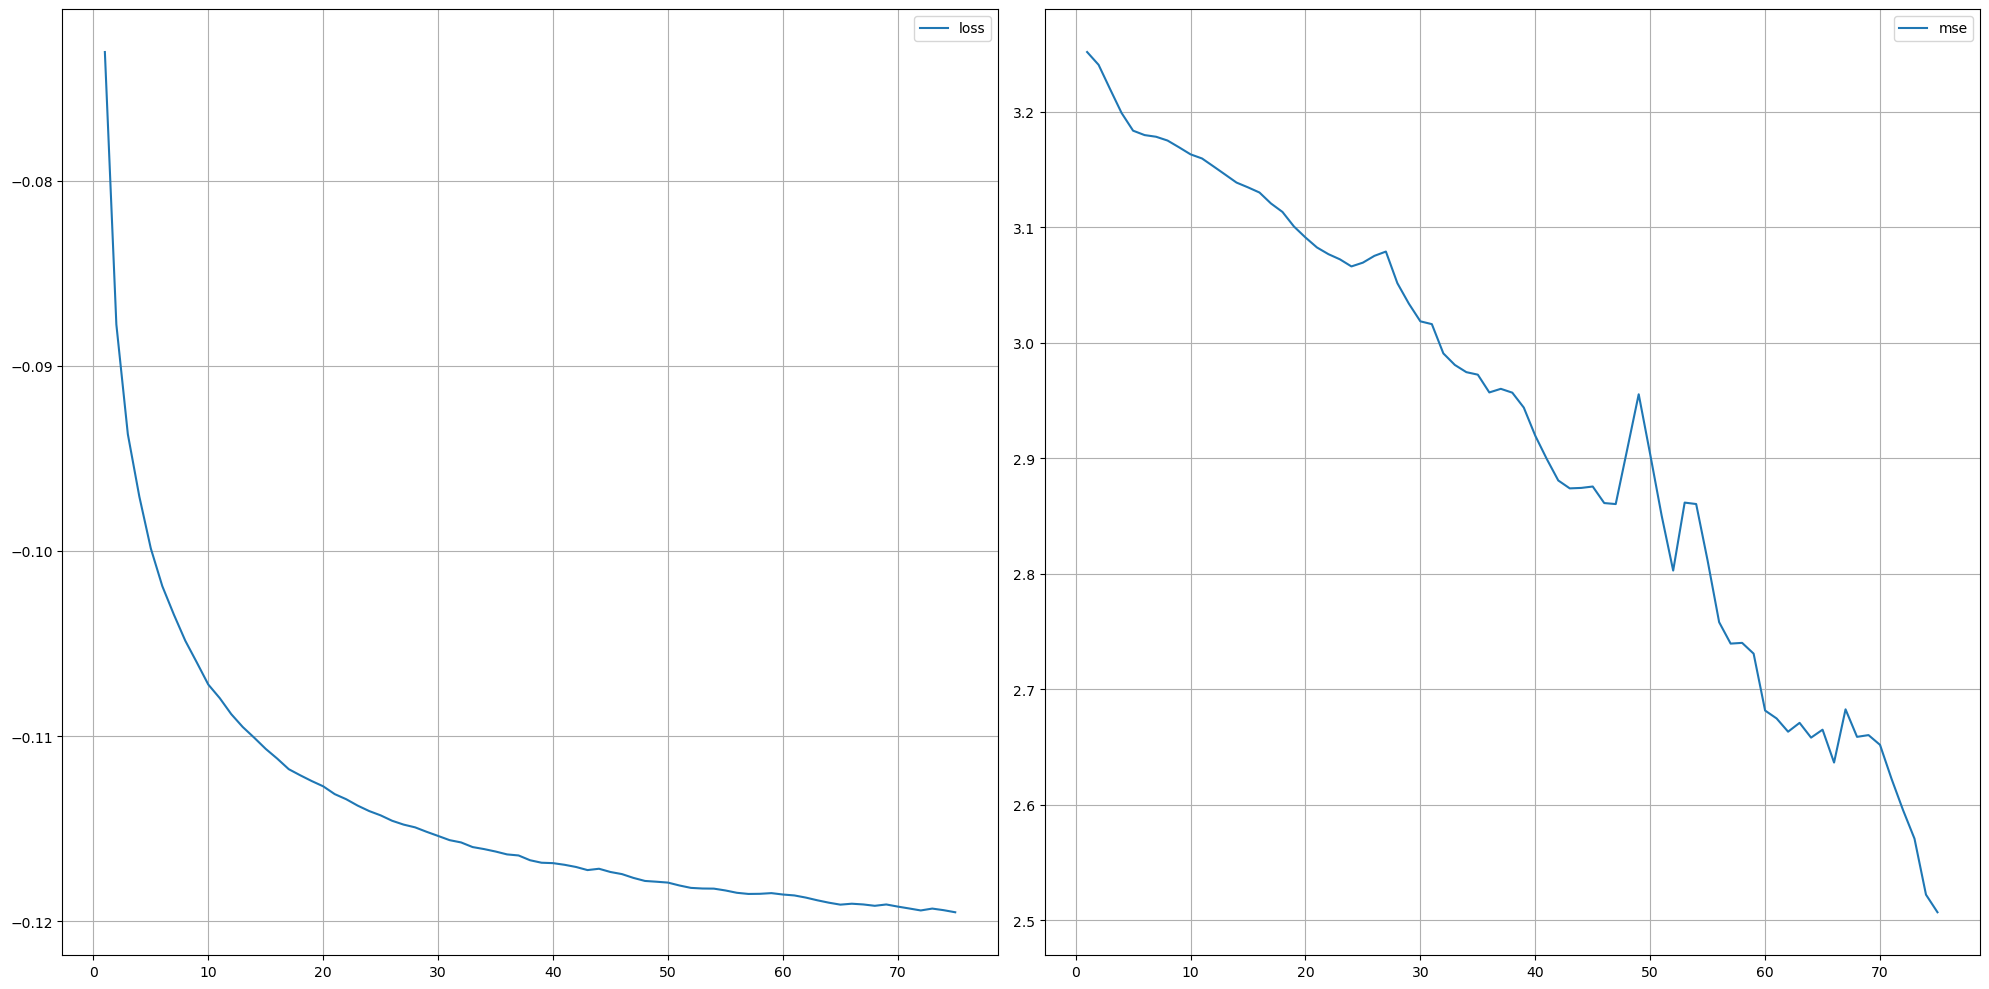

In [109]:
history = autoencoder.fit(talltokens, talltokens, batch_size=2, epochs=75, shuffle=True, verbose=0, callbacks=PlotLearning())

That model performance is unsatisfactory, with a cosine similarity of `~0.103`, it goes rather far from our input vector.
WE will now try deep neural autoencoding instead, on all three of our tensors (max, mean, all)

## BUT.
our current hypothesis is that if we scale all our word embeddings like this for just compression's sake then maybe similarity won't matter when we try to match them.
(in case this approach also does not work)

In [110]:
# trying again but with a deep neural network this time.
input_imgmax = keras.Input(shape=(300))
dencoded = Flatten()(input_imgmax)
dencoded = Dense(units=300/2, activation='relu')(dencoded)
dencoded = Dense(units=300/4, activation='relu')(dencoded)
dencoded = Dense(units=300/12, activation='relu')(dencoded)
dencoded = Dense(units=300/60, activation='relu')(dencoded)

ddecoded = Dense(units=300/12, activation='relu')(dencoded)
ddecoded = Dense(units=300/4, activation='relu')(ddecoded)
ddecoded = Dense(units=300/2, activation='relu')(ddecoded)
ddecoded = Dense(units=300, activation='relu')(ddecoded)

dmaxautoencoder = keras.Model(input_imgmax, ddecoded)
dmaxautoencoder.compile(optimizer='adam', loss=['cosine_similarity'], metrics=['mse'])
dmaxautoencoder.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 300)]             0         
                                                                 
 flatten_2 (Flatten)         (None, 300)               0         
                                                                 
 dense_18 (Dense)            (None, 150)               45150     
                                                                 
 dense_19 (Dense)            (None, 75)                11325     
                                                                 
 dense_20 (Dense)            (None, 25)                1900      
                                                                 
 dense_21 (Dense)            (None, 5)                 130       
                                                                 
 dense_22 (Dense)            (None, 25)                150

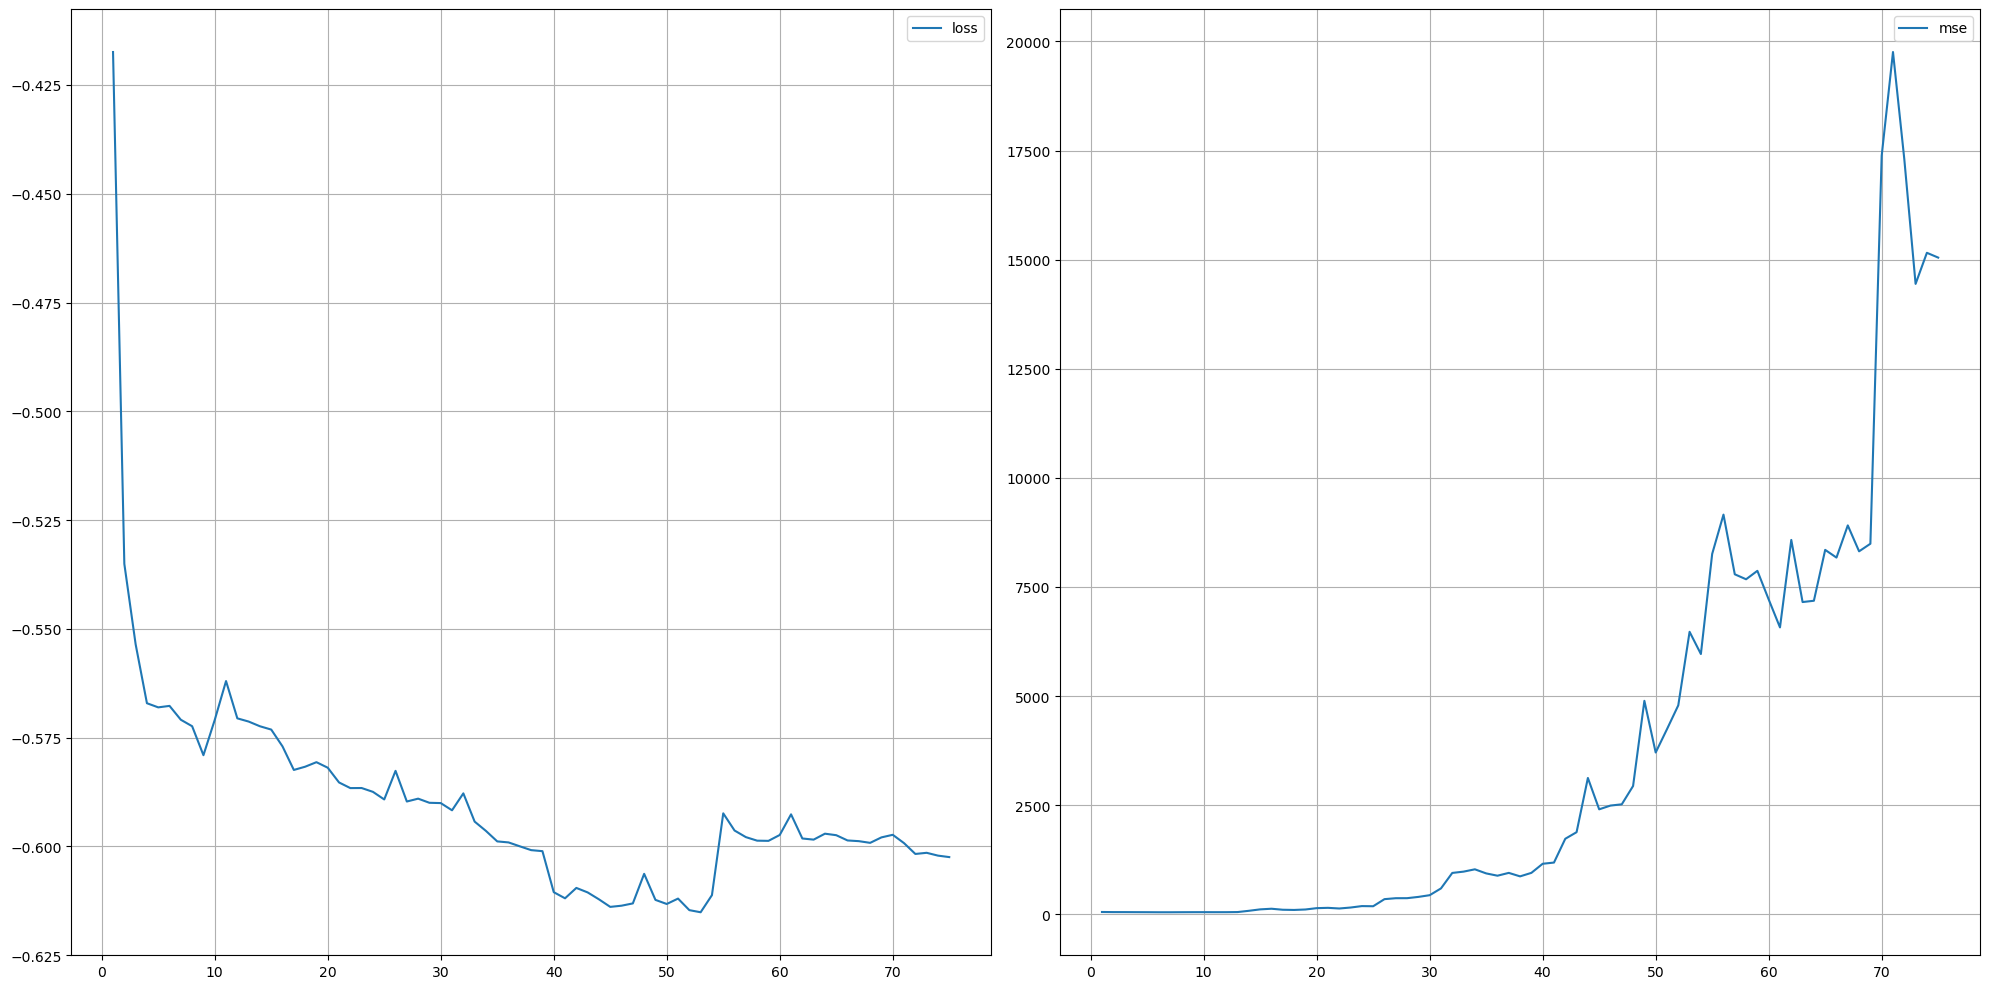

In [111]:
history = dmaxautoencoder.fit(tmaxtokens, tmaxtokens, batch_size=2, epochs=75, shuffle=True, verbose=0, callbacks=PlotLearning())

this is miles better, but the max pooling does mean there is a not insignificant loss of data here. will try flattening top 8 vectors and training the model

In [112]:
xdproc = layers.MaxPooling1D((32), padding='same')(input_img)
xdp = keras.Model(input_img, xdproc)
inpprep = xdp.predict(talltokens)

22/22 [==============================] - 0s 10ms/step


In [113]:

xdinput = keras.Input(shape=(8, 300))

xdencoded = Flatten()(xdinput)
xdencoded = Dense(units=300*4, activation='relu')(xdencoded)
xdencoded = Dense(units=300/2, activation='relu')(xdencoded)
xdencoded = Dense(units=300/4, activation='relu')(xdencoded)
xdencoded = Dense(units=300/12, activation='relu')(xdencoded)
xdencoded = Dense(units=300/60, activation='relu')(xdencoded)

xddecoded = Dense(units=300/12, activation='relu')(xdencoded)
xddecoded = Dense(units=300/4, activation='relu')(xddecoded)
xddecoded = Dense(units=300/2, activation='relu')(xddecoded)
xddecoded = Dense(units=300, activation='relu')(xddecoded)
xddecoded = Dense(units=300*8, activation='relu')(xddecoded)
xddecoded = Reshape((8, 300))(xddecoded)

xdmaxautoencoder = keras.Model(xdinput, xddecoded)
xdmaxautoencoder.compile(optimizer='adam', loss=['cosine_similarity'], metrics=['mse'])
xdmaxautoencoder.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 8, 300)]          0         
                                                                 
 flatten_3 (Flatten)         (None, 2400)              0         
                                                                 
 dense_26 (Dense)            (None, 1200)              2881200   
                                                                 
 dense_27 (Dense)            (None, 150)               180150    
                                                                 
 dense_28 (Dense)            (None, 75)                11325     
                                                                 
 dense_29 (Dense)            (None, 25)                1900      
                                                                 
 dense_30 (Dense)            (None, 5)                 130

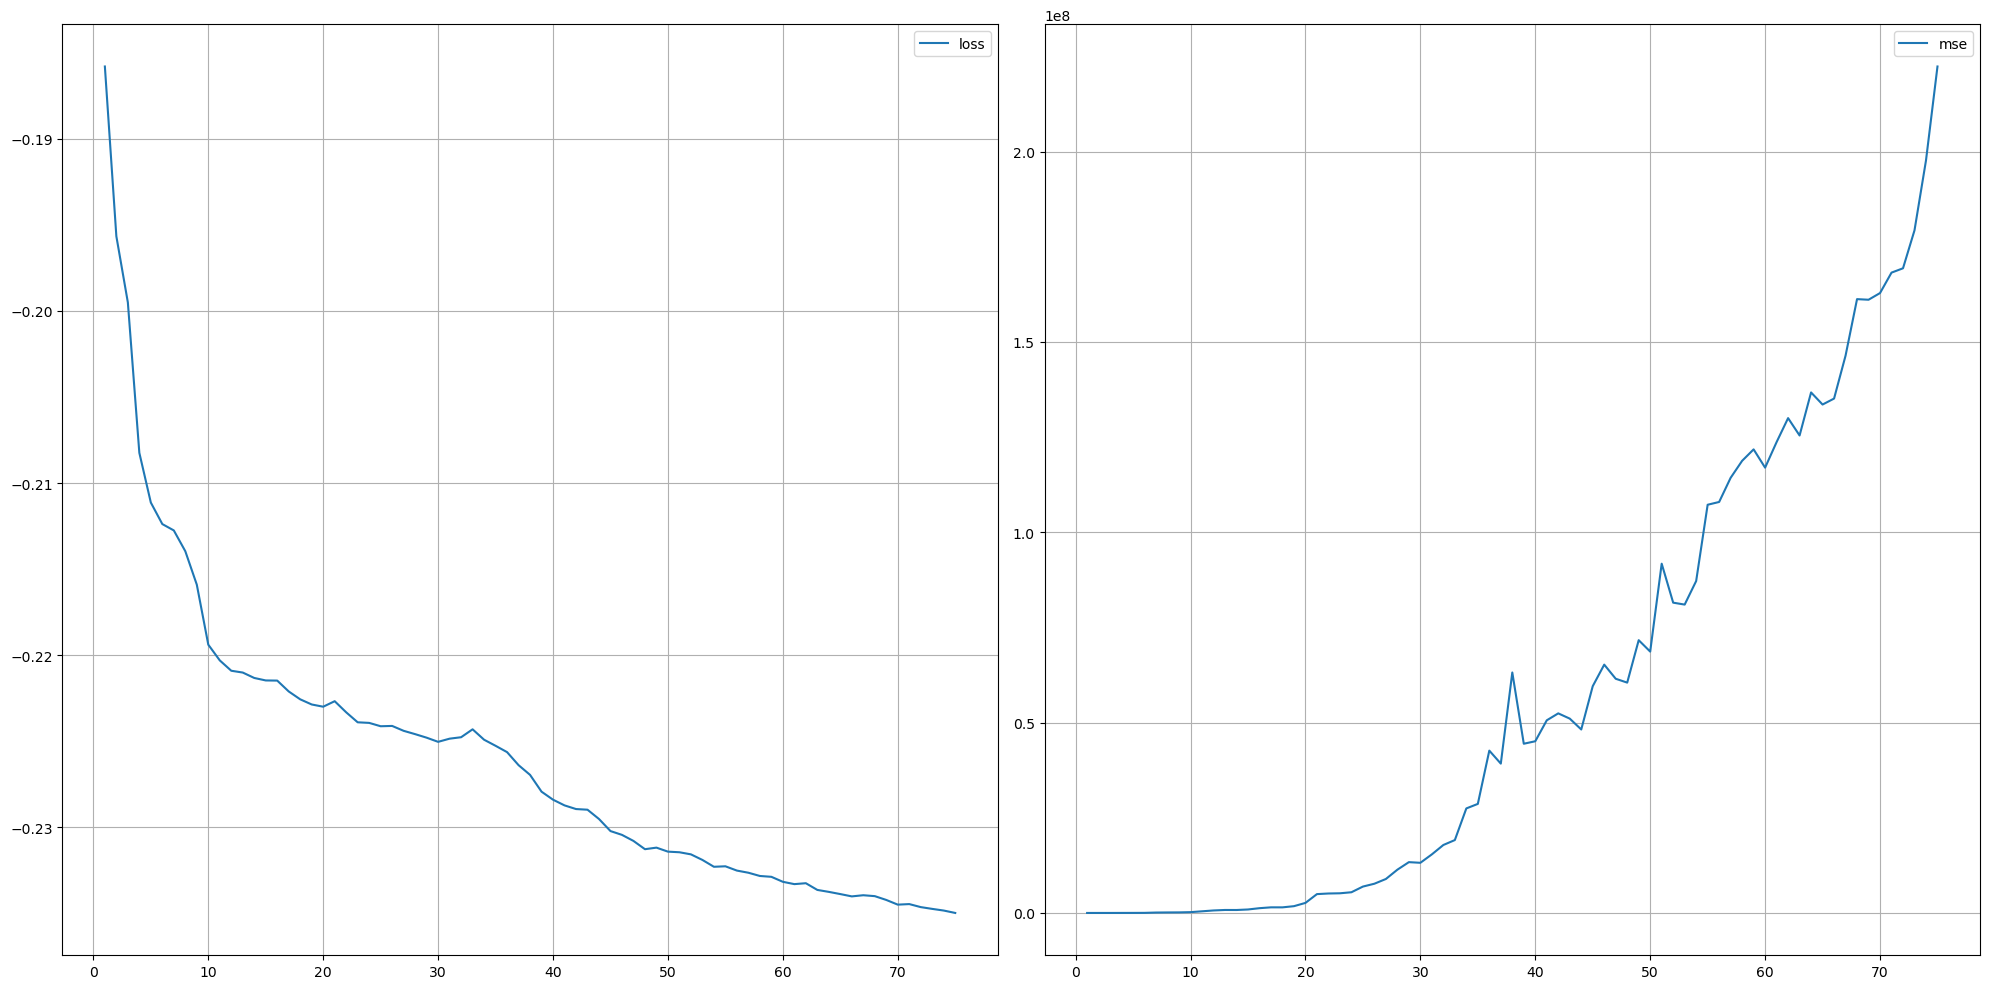

In [114]:
history = xdmaxautoencoder.fit(inpprep, inpprep, batch_size=2, epochs=75, shuffle=True, verbose=0, callbacks=PlotLearning())

so so far the max pooled one has worked the best. i wonder if i can get better results with mean, so i will rebuild the same model with mean.

In [115]:
dmeanautoencoder = keras.Model(input_imgmax, ddecoded)
dmeanautoencoder.compile(optimizer='adam', loss=['cosine_similarity'], metrics=['mse'])
dmeanautoencoder.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 300)]             0         
                                                                 
 flatten_2 (Flatten)         (None, 300)               0         
                                                                 
 dense_18 (Dense)            (None, 150)               45150     
                                                                 
 dense_19 (Dense)            (None, 75)                11325     
                                                                 
 dense_20 (Dense)            (None, 25)                1900      
                                                                 
 dense_21 (Dense)            (None, 5)                 130       
                                                                 
 dense_22 (Dense)            (None, 25)                150

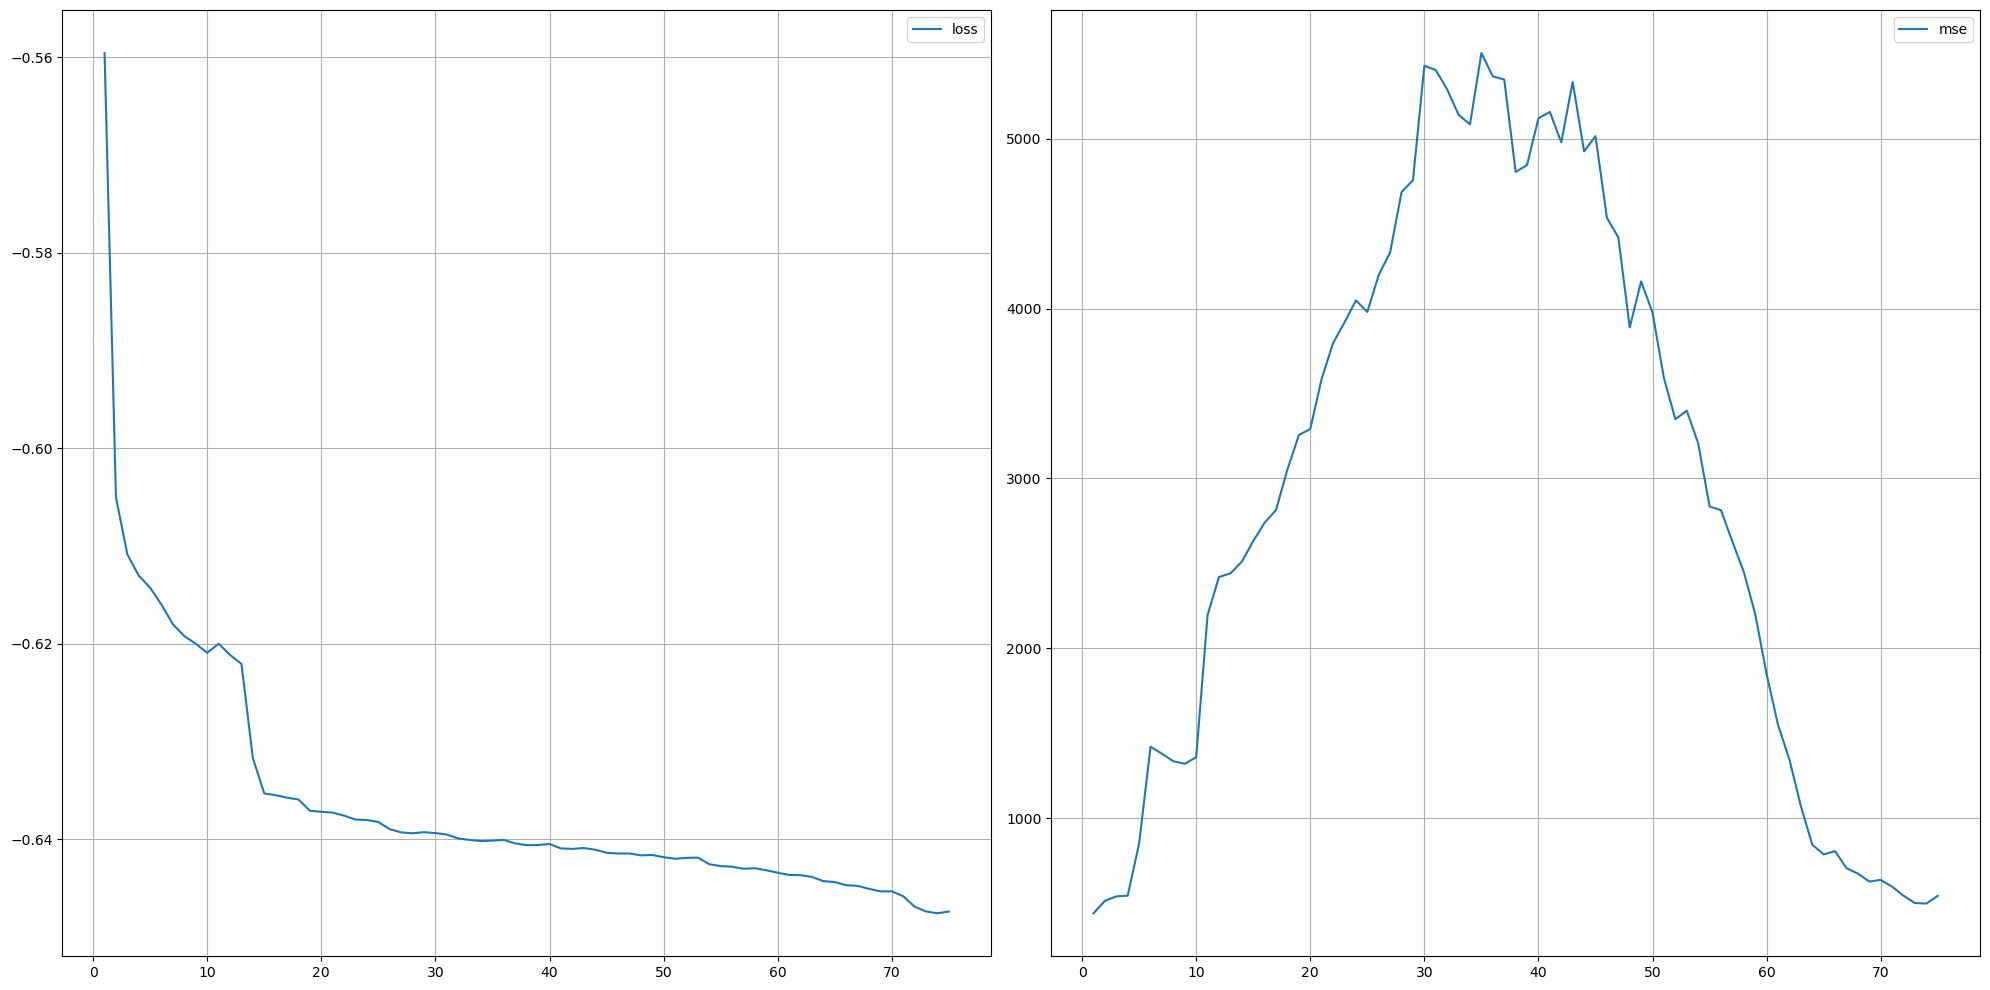

350/350 [==============================] - 2s 7ms/step - loss: -0.6474 - mse: 544.0282


In [116]:
history = dmeanautoencoder.fit(tmeantokens, tmeantokens, batch_size=2, epochs=75, shuffle=True, verbose=1, callbacks=PlotLearning())

Slightly better, but because of best practice concerns, we _MIGHT_ be using the max autoencoder for the demo.

In [117]:
# saving all the models, starting with the latest one
dmeanautoencoder.save('./models/bhagvadgita/mean_pooled_autoencoder.h5')

In [118]:
# saving the bad max pool model
xdmaxautoencoder.save('./models/bhagvadgita/top_8_max_pooled_autoencoder.h5')

In [119]:
# saving teh good max pool model
dmaxautoencoder.save('./models/bhagvadgita/BEST_max_pooled_autoencoder.h5')

In [120]:
# saving the conv1d model
autoencoder.save('./models/bhagvadgita/convolutional_autoencoder.h5')

now we can use the encoded values and save them with the dataframe

In [20]:
# splitting the model into just the encoder
dmeanautoencoder = tf.keras.models.load_model('./models/bhagvadgita/BEST_max_pooled_autoencoder.h5')
ourencoder = keras.Model(dmeanautoencoder.input, dmeanautoencoder.layers[5].output)

2023-04-10 21:11:47.812298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 21:11:47.814296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-10 21:11:47.814361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-10 21:11:47.814386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_nod

In [123]:
bhagvadgita_encodings = ourencoder.predict(tmeantokens)
encodf = pd.DataFrame(bhagvadgita_encodings, columns=('a1','a2','a3','a4','a5'))
encodf.head()
bhagvadgita_final = pd.concat([bhagvadgita, encodf], axis=1)
bhagvadgita_final.head()

,a1,a2,a3,a4,a5
0,82.410973,27.765862,0.0,0.0,104.664276
1,114.159912,54.171875,0.0,0.0,72.016129
2,173.533554,14.556988,0.0,0.0,86.657639
3,77.200554,22.392569,0.0,0.0,37.599243
4,139.233002,27.585991,0.0,0.0,64.782166


In [125]:
bhagvadgita_final.to_csv('../dataset/bhagvadgita_encoded.csv')

In [126]:
autoencoder.evaluate(talltokens, talltokens)

22/22 [==============================] - 2s 43ms/step - loss: -0.1200 - mse: 2.5072


[-0.12002787739038467, 2.5071985721588135]

In [130]:
dmaxautoencoder.evaluate(tmaxtokens, tmaxtokens)

22/22 [==============================] - 0s 3ms/step - loss: -0.3166 - mse: 31729.8457


[-0.31663915514945984, 31729.845703125]

In [128]:
xdmaxautoencoder.evaluate(inpprep, inpprep)

22/22 [==============================] - 0s 11ms/step - loss: -0.2354 - mse: 234676944.0000


[-0.2353964000940323, 234676944.0]

In [129]:
dmeanautoencoder.evaluate(tmeantokens, tmeantokens)

22/22 [==============================] - 0s 6ms/step - loss: -0.6485 - mse: 579.5543


[-0.6484894752502441, 579.5542602539062]

# PROD CODE

we be gaming now, converting all the holy books as encodings

In [ ]:
_, quran_tokens, _ = tensorgoBrr(quran, 'Verse')

In [32]:
splitlist = list(tf.split(quran_tokens, num_or_size_splits=4, axis=0))
quran_encodings = np.empty((0, 5))
for i in splitlist:
    quran_encodings = np.append(quran_encodings, ourencoder.predict(i), axis=0)
quran_encodings.shape

49/49 [==============================] - 0s 2ms/step


(6236, 5)

In [33]:
qencodf = pd.DataFrame(quran_encodings, columns=('a1','a2','a3','a4','a5'))
quran_final = pd.concat([quran, qencodf], axis=1)
quran_final.head()

,Name,Surah,Ayat,Verse,Tafseer,a1,a2,a3,a4,a5
0,The Opening,1,1,"In the name of Allah, the Beneficent, the Merc...",In the Name of God the Compassionate the Merciful,0.000000,1608.598389,1549.541016,3012.439209,0.0
1,The Opening,1,2,"Praise be to Allah, Lord of the Worlds,",In the Name of God the name of a thing is that...,743.423096,988.568298,1319.458008,0.000000,0.0
2,The Opening,1,3,"The Beneficent, the Merciful.",The Compassionate the Merciful that is to say ...,0.000000,1074.656860,1053.531006,2121.102783,0.0
3,The Opening,1,4,"Owner of the Day of Judgment,",Master of the Day of Judgement that is the day...,0.000000,1818.345703,1718.040283,4036.573486,0.0
4,The Opening,1,5,Thee (alone) we worship; Thee (alone) we ask f...,You alone we worship and You alone we ask for ...,0.000000,0.000000,0.000000,1035.581299,0.0


In [34]:
quran_final.to_csv('../dataset/quran_encoded.csv')

In [18]:
bibledata = np.array([nlp(i).vector.get() for i in bible['text']])

In [21]:
bible_encodings = np.empty((0, 5))
splitlist = np.split(bibledata, 19)
for i in splitlist:
    bible_encodings = np.append(bible_encodings, ourencoder.predict(i), axis=0)
bible_encodings.shape

52/52 [==============================] - 0s 2ms/step


(31103, 5)

In [23]:
bencodf = pd.DataFrame(bible_encodings, columns=('a1','a2','a3','a4','a5'))
bible_final = pd.concat([bible, bencodf], axis=1)
bible_final.head()

,field,book,chapter,verse,text,a1,a2,a3,a4,a5
0,1001001,1,1,1,At the first God made the heaven and the earth.,0.000000,1086.537598,1487.905762,895.738770,0.0
1,1001002,1,1,2,And the earth was waste and without form; and ...,0.000000,1404.235718,1748.230225,1488.695801,0.0
2,1001003,1,1,3,"And God said, Let there be light: and there wa...",1523.492676,1270.699219,778.843201,0.000000,0.0
3,1001004,1,1,4,"And God, looking on the light, saw that it was...",765.784241,819.540588,953.624695,0.000000,0.0
4,1001005,1,1,5,"Naming the light, Day, and the dark, Night. An...",0.000000,841.661438,1257.500610,522.869141,0.0


In [24]:
bible_final.to_csv('../dataset/bible_encoded.csv')